In [1]:
pip install pysptk pyworld librosa tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 461.9/461.9 kB 7.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 17.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pysptk: filename=pysptk-1.0.1-cp311-cp311-linux_x86_64.whl size=1293723 sha256=59d47cb2a538577b60f047971d5f418cc7bc4e14831983e7e171586b3753658c
  Stored in directory: /root/.cache/pip/wheels/f7/8e/e6/be2295ab3cba2d52e826922cd3ea8bda4a18210c03584dc759
  Created wheel for pyworld: filename=pyworld-0.3.5-cp311-cp311-linux_x86_64.whl size=899906 sha256=524f7619dcada425bdb6c20d7df562839c36f3d2b53a2a9e448d71dcd47ac334
  Stored in directory: /root/.cache/pip/wheels/26/f0/db/ebcd5cdfe5ad7d229917d3a8db6f18f0cf40f099bf878e294d
Successfully built pys

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os

directory_path = "/content/drive/MyDrive/NewData"

if os.path.exists(directory_path):
    print(f"The directory '{directory_path}' exists.")
else:
    print(f"The directory '{directory_path}' does not exist.")

The directory '/content/drive/MyDrive/NewData' exists.


In [5]:
# !wget -P /content/drive/MyDrive/NewData "http://festvox.org/cmu_arctic/cmu_arctic/packed/cmu_us_slt_arctic-0.95-release.tar.bz2"

In [6]:
# !tar -xvjf /content/drive/MyDrive/NewData/cmu_us_bdl_arctic-0.95-release.tar.bz2 -C /content/drive/MyDrive/NewData/
# !tar -xvjf /content/drive/MyDrive/NewData/cmu_us_clb_arctic-0.95-release.tar.bz2 -C /content/drive/MyDrive/NewData/
# !tar -xvjf /content/drive/MyDrive/NewData/cmu_us_jmk_arctic-0.95-release.tar.bz2 -C /content/drive/MyDrive/NewData/
# !tar -xvjf /content/drive/MyDrive/NewData/cmu_us_ksp_arctic-0.95-release.tar.bz2 -C /content/drive/MyDrive/NewData/
# !tar -xvjf /content/drive/MyDrive/NewData/cmu_us_rms_arctic-0.95-release.tar.bz2 -C /content/drive/MyDrive/NewData/
# !tar -xvjf /content/drive/MyDrive/NewData/cmu_us_slt_arctic-0.95-release.tar.bz2 -C /content/drive/MyDrive/NewData/


In [7]:
from os.path import join, expanduser
DATA_ROOT = join("/content", "drive", "MyDrive", "NewData")
print(DATA_ROOT)
!ls $DATA_ROOT

/content/drive/MyDrive/NewData
cmu_us_awb_arctic  cmu_us_clb_arctic  cmu_us_ksp_arctic  cmu_us_slt_arctic
cmu_us_bdl_arctic  cmu_us_jmk_arctic  cmu_us_rms_arctic


In [8]:
%pylab inline
rcParams["figure.figsize"] = (16,5)

!pip install nnmnkwii


Populating the interactive namespace from numpy and matplotlib
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nnmnkwii: filename=nnmnkwii-0.1.3-cp311-cp311-linux_x86_64.whl size=3768491 sha256=ecbc48f13a8b23debd5931bd3bee27a55c8328b81397f5bab27fcbd48b437818
  Stored in directory: /root/.cache/pip/wheels/18/98/9e/f02110e10183689a04fdffa478e825392a6b9fdabee4ed968f
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp311-cp311-linux_x86_64.whl size=542099 sha256=59d9d66dad24081fe39468c4b18ff8f687048306fc610bd25f8fd7f41f38268f
  Stored in directory: /root/.cache/pip/wheels/5c/8a/f6/fd3df9a9714677410a5ccbf3ca519e66db4a54a1c46ea95332
Successfully built nnmnkwii fastdtw


In [9]:
import nnmnkwii

from nnmnkwii.datasets import PaddedFileSourceDataset
from nnmnkwii.datasets.cmu_arctic import CMUArcticWavFileDataSource
from nnmnkwii.preprocessing.alignment import DTWAligner
from nnmnkwii.preprocessing import trim_zeros_frames, remove_zeros_frames, delta_features
from nnmnkwii.util import apply_each2d_trim
from nnmnkwii.metrics import melcd
from nnmnkwii.baseline.gmm import MLPG

from os.path import basename, splitext
import sys
import time

import numpy as np
from scipy.io import wavfile
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
import pyworld
import pysptk
from pysptk.synthesis import MLSADF, Synthesizer
import librosa
import librosa.display
import IPython
from IPython.display import Audio

In [10]:
fs = 16000
fftlen = pyworld.get_cheaptrick_fft_size(fs)
alpha = pysptk.util.mcepalpha(fs)
order = 24
frame_period = 5
hop_length = int(fs * (frame_period * 0.001))
max_files = 100 # number of utterances to be used.
test_size = 0.03
use_delta = True

if use_delta:
    windows = [
        (0, 0, np.array([1.0])),
        (1, 1, np.array([-0.5, 0.0, 0.5])),
        (1, 1, np.array([1.0, -2.0, 1.0])),
    ]
else:
    windows = [
        (0, 0, np.array([1.0])),
    ]

In [11]:
class MyFileDataSource(CMUArcticWavFileDataSource):
    def __init__(self, *args, **kwargs):
        super(MyFileDataSource, self).__init__(*args, **kwargs)
        self.test_paths = None

    def collect_files(self):
        paths = super(
            MyFileDataSource, self).collect_files()
        paths_train, paths_test = train_test_split(
            paths, test_size=test_size, random_state=1234)

        # keep paths for later testing
        self.test_paths = paths_test

        return paths_train

    def collect_features(self, path):
        fs, x = wavfile.read(path)
        x = x.astype(np.float64)
        f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
        f0 = pyworld.stonemask(x, f0, timeaxis, fs)
        spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
        spectrogram = trim_zeros_frames(spectrogram)
        mc = pysptk.sp2mc(spectrogram, order=order, alpha=alpha)
        return mc

In [12]:
clb_source = MyFileDataSource(data_root=DATA_ROOT,
                                         speakers=["clb"], max_files=max_files)
slt_source = MyFileDataSource(data_root=DATA_ROOT,
                                         speakers=["slt"], max_files=max_files)

In [13]:
X = PaddedFileSourceDataset(clb_source, 1200).asarray()
Y = PaddedFileSourceDataset(slt_source, 1200).asarray()
print(X.shape)
print(Y.shape)

(97, 1200, 25)
(97, 1200, 25)


One of the pairs of our dataset visualized

In [14]:
# Plotting util
def plot_parallel(x,y):
    figure(figsize=(16,7))
    subplot(2,1,1)
    librosa.display.specshow(trim_zeros_frames(x).T, sr=fs, hop_length=hop_length, x_axis="time")
    colorbar()
    subplot(2,1,2)
    librosa.display.specshow(trim_zeros_frames(y).T, sr=fs, hop_length=hop_length, x_axis="time")
    colorbar()

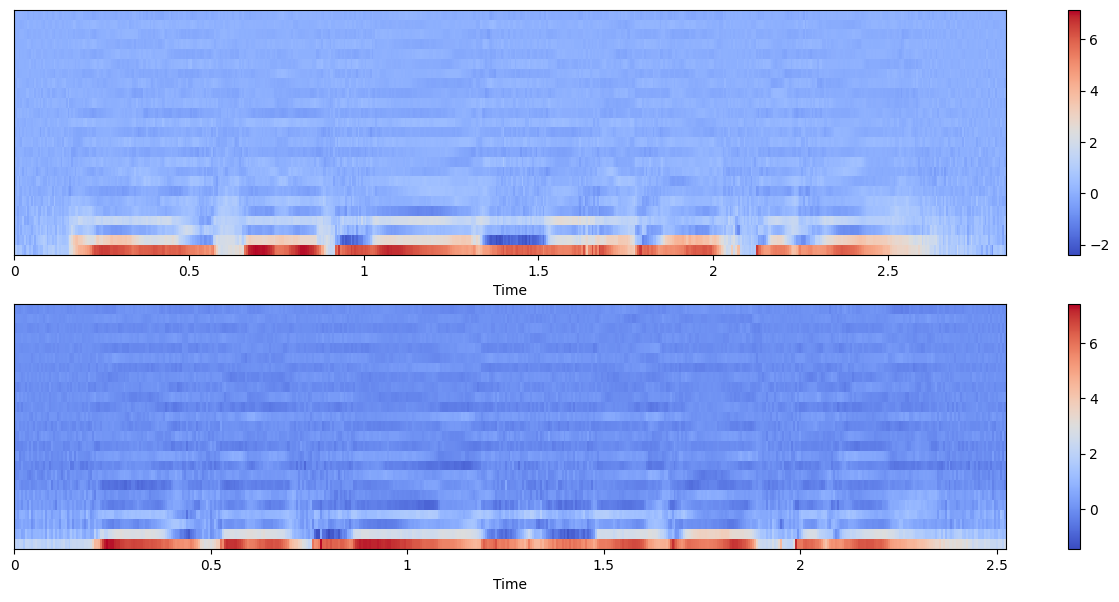

In [15]:
idx = 22 # any
plot_parallel(X[idx],Y[idx])

Now Aligning Source and Target Features

In [16]:
X_aligned, Y_aligned = DTWAligner(verbose=0, dist=melcd).transform((X, Y))


Let's see how the data looks like now

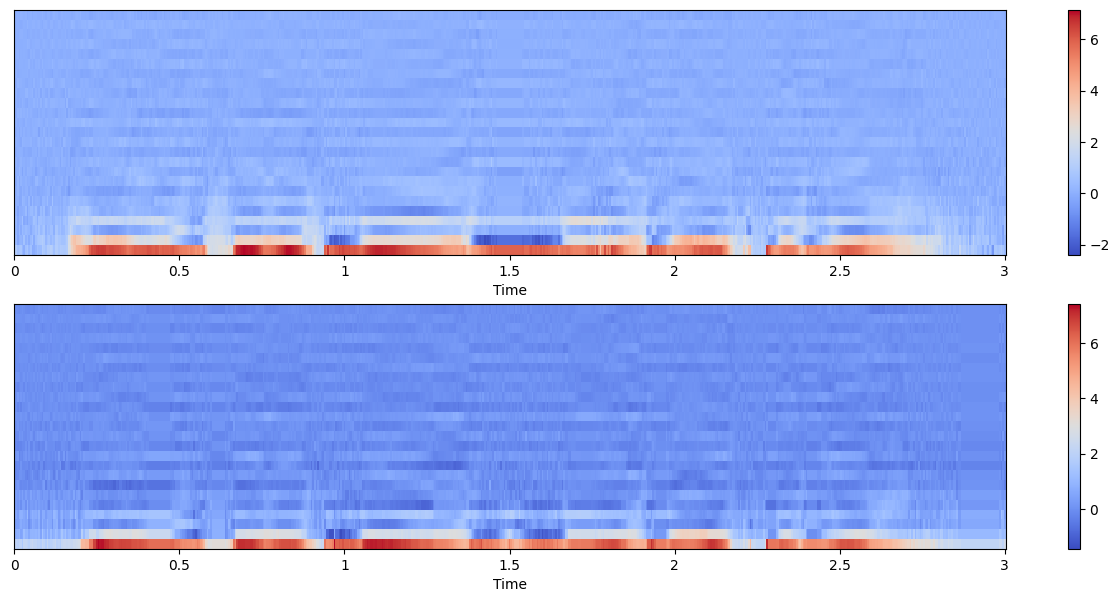

In [17]:
plot_parallel(X_aligned[idx],Y_aligned[idx])

Dropping the 1st dimension or [0] of the mel-cepstrum, coz it defines the energy or loudness of voice and we dont consider that as a spectral property to be retained while voice conversion

In [18]:
# Drop 1st (power) dimension
X_aligned, Y_aligned = X_aligned[:, :, 1:], Y_aligned[:, :, 1:]

Append delta features


In [19]:
static_dim = X_aligned.shape[-1]
if use_delta:
    X_aligned = apply_each2d_trim(delta_features, X_aligned, windows)
    Y_aligned = apply_each2d_trim(delta_features, Y_aligned, windows)

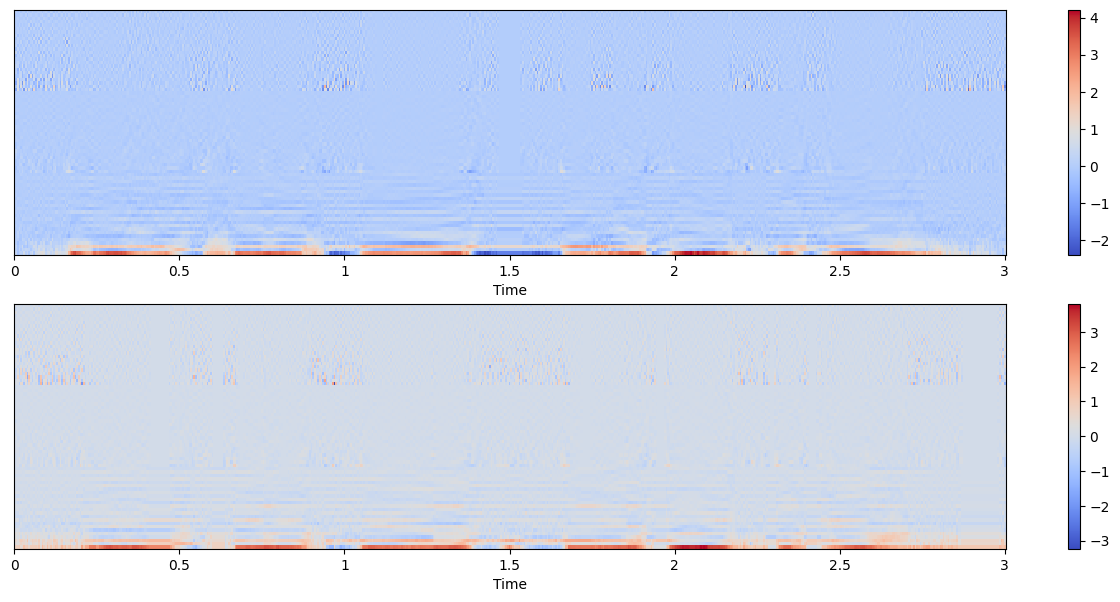

In [21]:
plot_parallel(X_aligned[idx],Y_aligned[idx])


In [22]:
XY = np.concatenate((X_aligned, Y_aligned), axis=-1).reshape(-1, X_aligned.shape[-1]*2)
print(XY.shape)

(116400, 144)


In [23]:
XY = remove_zeros_frames(XY)
print(XY.shape)

(68186, 144)


In [24]:
gmm = GaussianMixture(
    n_components=64, covariance_type="full", max_iter=100, verbose=1)

%time gmm.fit(XY)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged.
CPU times: user 37min 16s, sys: 13min 45s, total: 51min 2s
Wall time: 31min 57s


GaussianMixture(n_components=64, verbose=1)

Visualize model: Viewing the parameters of GMM

Means

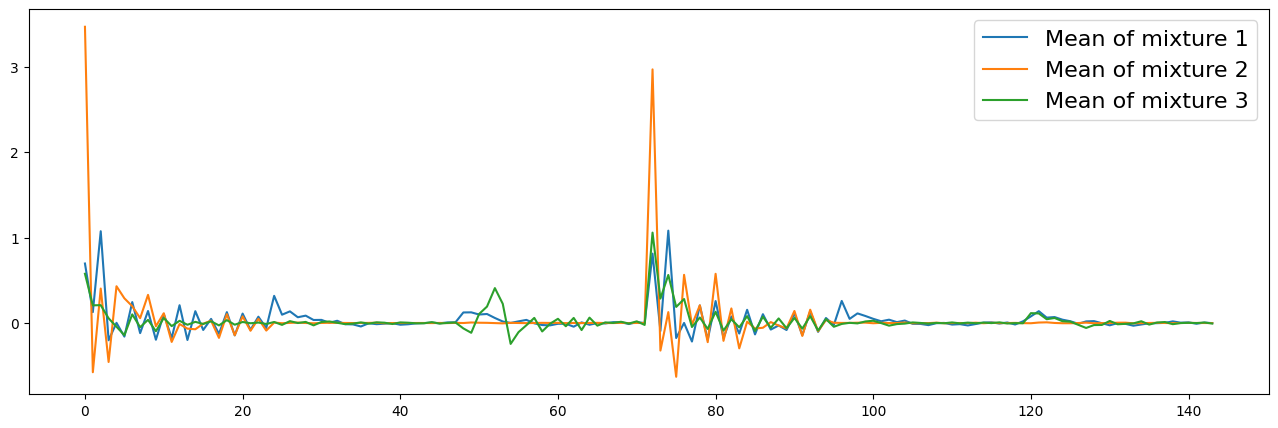

In [25]:
for k in range(3):
    plot(gmm.means_[k], linewidth=1.5, label="Mean of mixture {}".format(k+1))
legend(prop={"size": 16})

Covariances

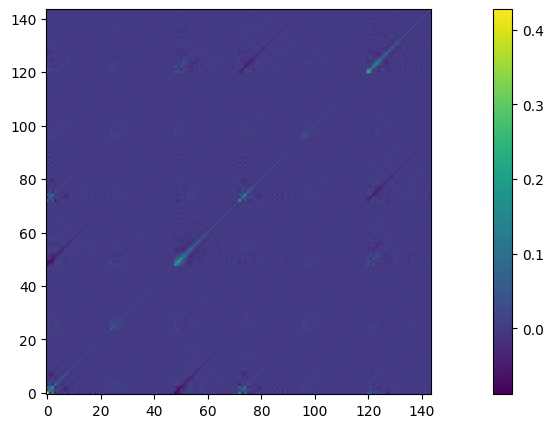

In [27]:
imshow(gmm.covariances_[0], origin="lower")
colorbar()

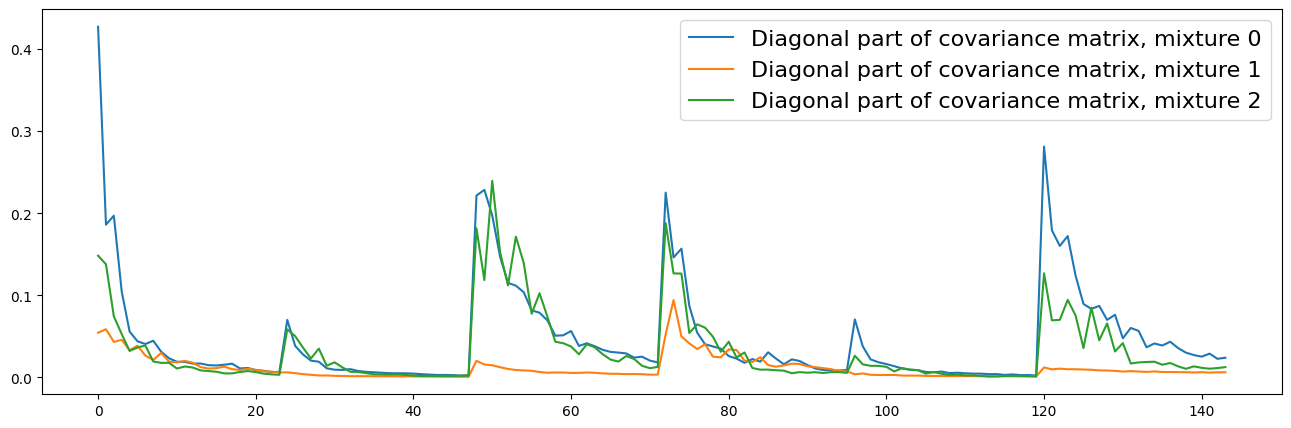

In [28]:
for k in range(3):
    plot(np.diag(gmm.covariances_[k]), linewidth=1.5,
         label="Diagonal part of covariance matrix, mixture {}".format(k))
legend(prop={"size": 16})

Testing: Parameter Generation Using MLPG

In [29]:
def test_one_utt(src_path, tgt_path, disable_mlpg=False, diffvc=True):
    # GMM-based parameter generation is provided by the library in `baseline` module
    if disable_mlpg:
        # Force disable MLPG
        paramgen = MLPG(gmm, windows=[(0,0, np.array([1.0]))], diff=diffvc)
    else:
        paramgen = MLPG(gmm, windows=windows, diff=diffvc)

    fs, x = wavfile.read(src_path)
    x = x.astype(np.float64)
    f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
    f0 = pyworld.stonemask(x, f0, timeaxis, fs)
    spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
    aperiodicity = pyworld.d4c(x, f0, timeaxis, fs)

    mc = pysptk.sp2mc(spectrogram, order=order, alpha=alpha)
    c0, mc = mc[:, 0], mc[:, 1:]
    if use_delta:
        mc = delta_features(mc, windows)
    mc = paramgen.transform(mc)
    if disable_mlpg and mc.shape[-1] != static_dim:
        mc = mc[:,:static_dim]
    assert mc.shape[-1] == static_dim
    mc = np.hstack((c0[:, None], mc))
    if diffvc:
        mc[:, 0] = 0 # remove power coefficients
        engine = Synthesizer(MLSADF(order=order, alpha=alpha), hopsize=hop_length)
        b = pysptk.mc2b(mc.astype(np.float64), alpha=alpha)
        waveform = engine.synthesis(x, b)
    else:
        spectrogram = pysptk.mc2sp(
            mc.astype(np.float64), alpha=alpha, fftlen=fftlen)
        waveform = pyworld.synthesize(
            f0, spectrogram, aperiodicity, fs, frame_period)

    return waveform


In [30]:
for i, (src_path, tgt_path) in enumerate(zip(clb_source.test_paths, slt_source.test_paths)):
    print("{}-th sample".format(i+1))
    wo_MLPG = test_one_utt(src_path, tgt_path, disable_mlpg=True)
    w_MLPG = test_one_utt(src_path, tgt_path, disable_mlpg=False)
    _, src = wavfile.read(src_path)
    _, tgt = wavfile.read(tgt_path)

    print("Source:", basename(src_path))
    IPython.display.display(Audio(src, rate=fs))
    print("Target:", basename(tgt_path))
    IPython.display.display(Audio(tgt, rate=fs))
    print("w/o MLPG")
    IPython.display.display(Audio(wo_MLPG, rate=fs))
    print("w/ MLPG")
    IPython.display.display(Audio(w_MLPG, rate=fs))

1-th sample
Source: arctic_a0041.wav


Target: arctic_a0041.wav


w/o MLPG


w/ MLPG


2-th sample
Source: arctic_a0036.wav


Target: arctic_a0036.wav


w/o MLPG


w/ MLPG


3-th sample
Source: arctic_a0082.wav


Target: arctic_a0082.wav


w/o MLPG


w/ MLPG


How different are they?

In [31]:
def vis_difference(x, y, which_dims=[0,2,3,6,8], T_max=None):
    static_paramgen = MLPG(gmm, windows=[(0,0, np.array([1.0]))], diff=False)
    paramgen = MLPG(gmm, windows=windows, diff=False)

    x = trim_zeros_frames(x)
    y = trim_zeros_frames(y)[:,:static_dim]
    y_hat1 = static_paramgen.transform(x)[:,:static_dim]
    y_hat2 = paramgen.transform(x)

    if T_max is not None and len(y) > T_max:
        y,y_hat1,y_hat2 = y[:T_max],y_hat1[:T_max],y_hat2[:T_max]

    figure(figsize=(16,4*len(which_dims)))
    for idx, which_dim in enumerate(which_dims):
        subplot(len(which_dims), 1, idx+1)
        plot(y[:,which_dim], "--", linewidth=1, label="Target")
        plot(y_hat1[:,which_dim], "-", linewidth=2, label="w/o MLPG")
        plot(y_hat2[:,which_dim], "-", linewidth=3, label="w/ MLPG")
        title("{}-th coef".format(which_dim+1), fontsize=16)
        legend(prop={"size": 16}, loc="upper right")

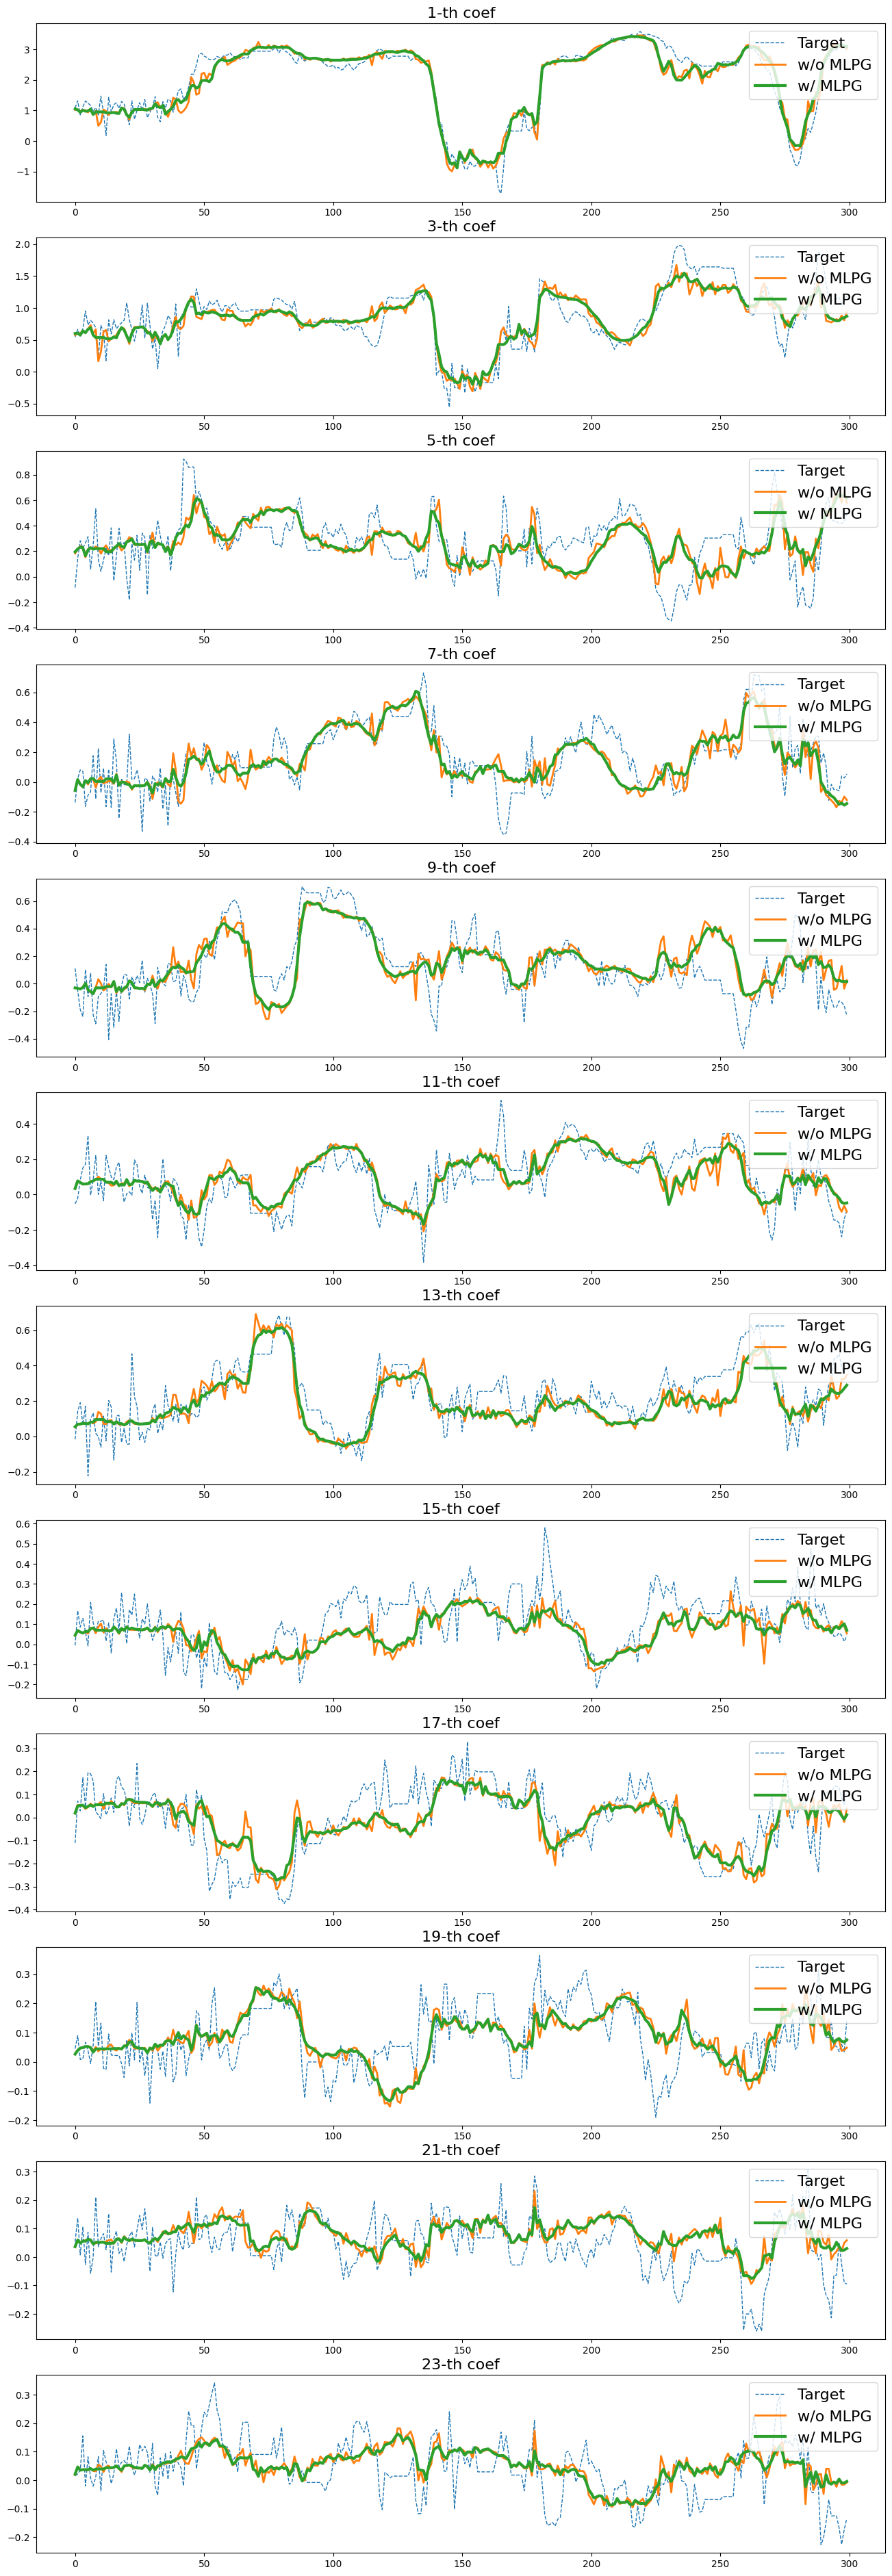

In [32]:
idx = 0
which_dims = np.arange(0, static_dim, step=2)
vis_difference(X_aligned[idx], Y_aligned[idx], T_max=300, which_dims=which_dims)